# Metcalfe's Law and Bitcoin Price


The aim of this notebook is provide BTC price range estimate based the the amount of BTC wallets using [Metcalfe's Law](https://en.wikipedia.org/wiki/Metcalfe%27s_law).

According to [Metcalfe's Law](https://en.wikipedia.org/wiki/Metcalfe%27s_law) a value of networks (fully deluted market cap) is proportinal to the number of possible connection between their participants (wallets). As each partcipant can have _n-1_ connection, the value of the network, not cosidering the cost of the network, is :

> V=An(n-1)/2

If n is large and k=A/2 :

> V = k * n^2

_n_ is equated to the number of BTC addresses (_addressesCount_) holding more than a certain amount of BTC (0.1/0.01/0.001)


In [1]:
import requests
import json
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'


from datetime import date
import time

# ----- User Settings 

coins=['BTC']  # Only BTC is available at cryptocompare


data_fetch_start_date = '2010-01-01'
plot_start_date = '2010-09-01'
k_calibration_start_date = '2017-01-01'
linear_fitting_start_date='2021-01-01'
extrapolation_end_date ='2037-06-26'

# Having more or same amount of BTC as [x,y,z]. This is for filtering out empty wallets
# min_btcs =  [1000, 100, 10, 1, 0.1, 0.01, 0.001]
min_btcs = [1e-08, 0.001, 0.01, 0.1, 1, 10]

# Reuqested Simple Moving Averages for calucating k
smas = [1,2,7,30,90,180, 365]


# cryptocompare.com API Key for fetching BTC wallet distributions and price
cryptocompare_api_key = '777db0605f662ba6667a0c8d385d317262bd221764d4a3b01dc7a629e9592a49'
# https://data.nasdaq.com/ token to use nasdaqdatalink for M2 money supply
nasdaqdatalink_token = 'JEn6xy3nc1JtFSLoXoVJ'
# https://fred.stlouisfed.org/
fred_api_key = 'b121cc395b21e22273f7275e8c49a2d0'
# ----- User Settings -- end





requestUrls = ['https://min-api.cryptocompare.com/data/blockchain/balancedistribution/histo/day?fsym={}&api_key={}&toTs={}&limit={}',
              'https://min-api.cryptocompare.com/data/v2/histoday?fsym={}&tsym=USD&api_key={}&toTs={}&limit={}']


limit=2000
data_fetch_start_date_ts = pd.Timestamp(data_fetch_start_date)
coin_dfs=[]
for coin in coins:
    time_segments = []
    timestamp = pd.Timestamp.now()
    while data_fetch_start_date_ts <= timestamp : 
        segment_dfs = []
        for requestUrl in requestUrls:
            segment_df = pd.DataFrame()
            requestUrl = requestUrl.format(coin, cryptocompare_api_key, timestamp.timestamp(),limit)
            # print("Request : " + requestUrl)    
            response = requests.get(requestUrl).text 
            parsed = json.loads(response)
            # print("Json : \n\n" + response)
            segment_df = pd.DataFrame(parsed['Data']['Data'])
            segment_df['time'] = pd.to_datetime(segment_df['time'], unit='s')
            segment_df.set_index(['time'],inplace=True, verify_integrity = True, drop = True)
            segment_df.sort_index(inplace=True)
            segment_dfs.append(segment_df)
        
        #segment_df.drop_duplicates(inplace=True)
        concated_segment_dfs= pd.concat(segment_dfs,axis=1)
        time_segments.append(concated_segment_dfs) 
        
        timestamp = segment_df.first_valid_index() - pd.Timedelta(1, "d") # -1 day    
        concated_segment_dfs.drop(columns=['volumefrom','volumeto','conversionType'
                                           ,'conversionSymbol', 'open','high','low'
                                           ,'id','symbol','partner_symbol'], inplace=True)
        #print("seg tail {}".format(concated_segment_dfs.tail(1)))

    df = pd.concat(time_segments, axis=0)
    df.sort_index(inplace=True)
    # print("Df {}\n".format(df))    
    df.dropna(inplace=True)
    df_wallet_ranges = [] 
    for i in range(10):
        df_wallet_range = pd.DataFrame()
        df_wallet_range['addressesCount'] = df['balance_distribution'].map(lambda x: x[i]['addressesCount'])
        df_wallet_range['totalVolume'] = df['balance_distribution'].map(lambda x: x[i]['totalVolume'])
        vindex= df.first_valid_index()  
        range_name = "{}-{}".format(df.loc[vindex,['balance_distribution']][0][i]['from'], 
                                    df.loc[vindex,['balance_distribution']][0][i]['to'])
        df_wallet_range =  pd.concat({range_name: df_wallet_range}, axis=1, names=["wallet_range", "metrics"]) 
        df_wallet_ranges.append(df_wallet_range)
    range_name = "all"
    df_wallet_range = pd.DataFrame()
    df_wallet_range['price'] = df['close']
    df_wallet_range = pd.concat({range_name: df_wallet_range}, axis=1, names=["wallet_range", "metrics"]) 
    df_wallet_ranges.append(df_wallet_range)
    
    df = pd.concat(df_wallet_ranges, axis=1)
 
    df = pd.concat({coin: df}, axis=1, names=["coin", "wallet_range", "metrics"])
    coin_dfs.append(df)
df=pd.concat(coin_dfs, axis=1)
df=df.loc[data_fetch_start_date_ts:]
df.sort_index(inplace=True)
df

coin                    BTC                                            \
wallet_range    1e-08-0.001                  0.001-0.01                 
metrics      addressesCount  totalVolume addressesCount   totalVolume   
time                                                                    
2010-01-01                0     0.000000              0      0.000000   
2010-01-02                0     0.000000              0      0.000000   
2010-01-03                0     0.000000              0      0.000000   
2010-01-04                0     0.000000              0      0.000000   
2010-01-05                0     0.000000              0      0.000000   
...                     ...          ...            ...           ...   
2023-12-21         27252782  5640.481293       12301951  44869.184221   
2023-12-22         27267033  5646.508437       12305834  44852.881423   
2023-12-23         27303043  5655.732066       12288361  44828.299447   
2023-12-24         27350631  5664.453593       12295281  44832.274668   
2023-12-25         27381644  5675.262167       12311567  44882.531910   

coin                                                                     \
wallet_range       0.01-0.1                         0.1-1                 
metrics      addressesCount    totalVolume addressesCount   totalVolume   
time                                                                      
2010-01-01                6       0.080000              3  1.500000e+00   
2010-01-02                6       0.080000              3  1.500000e+00   
2010-01-03                6       0.080000              3  1.500000e+00   
2010-01-04                6       0.080000              3  1.500000e+00   
2010-01-05                6       0.080000              3  1.500000e+00   
...                     ...            ...            ...           ...   
2023-12-21          8140116  274181.576477        3559771  1.100495e+06   
2023-12-22          8139320  274142.550265        3557676  1.099868e+06   
2023-12-23          8140019  273977.480065        3556053  1.099522e+06   
2023-12-24          8138175  273956.657470        3555525  1.099496e+06   
2023-12-25          8139388  273890.734767        3553855  1.099033e+06   

coin                                       ...                               \
wallet_range           1-10                ...        10-100       100-1000   
metrics      addressesCount   totalVolume  ...   totalVolume addressesCount   
time                                       ...                                
2010-01-01               10  2.344000e+01  ...  1.494773e+06             26   
2010-01-02               10  2.344000e+01  ...  1.501073e+06             26   
2010-01-03               10  2.344000e+01  ...  1.510373e+06             26   
2010-01-04               10  2.344000e+01  ...  1.515399e+06             26   
2010-01-05               10  2.344000e+01  ...  1.525299e+06             26   
...                     ...           ...  ...           ...            ...   
2023-12-21           867978  2.155350e+06  ...  4.431428e+06          13907   
2023-12-22           867839  2.155546e+06  ...  4.431354e+06          13931   
2023-12-23           867864  2.155841e+06  ...  4.430737e+06          13949   
2023-12-24           868041  2.156818e+06  ...  4.430694e+06          13950   
2023-12-25           867672  2.155792e+06  ...  4.432296e+06          13917   

coin                                                                    \
wallet_range                   1000-10000                 10000-100000   
metrics        totalVolume addressesCount   totalVolume addressesCount   
time                                                                     
2010-01-01    8.623200e+03              5  1.780001e+04              4   
2010-01-02    8.623200e+03              5  1.780001e+04              4   
2010-01-03    8.623200e+03              5  1.780001e+04              4   
2010-01-04    7.896860e+03              5  1.780001e+04              4   


In [2]:
df_aux = pd.DataFrame()

coin = coins[0] # 'BTC'

#aggregate_wallets=['0.1-1','1-10', '10-100','100-1000', '1000-10000', '10000-100000', '100000-1000000']
aggregate_wallets=['10000-100000']

aggregate_wallets.append('1000-10000')
addressCounts = [df[coin][w_range]['addressesCount'] for w_range in aggregate_wallets]
df_aux['addressesCount'] = sum(addressCounts)
df.loc(axis=1)[(coin,'1000+','addressesCount')] = df_aux['addressesCount']


aggregate_wallets.append('100-1000')
addressCounts = [df[coin][w_range]['addressesCount'] for w_range in aggregate_wallets]
df_aux['addressesCount'] = sum(addressCounts)
df.loc(axis=1)[(coin,'100+','addressesCount')] = df_aux['addressesCount']

aggregate_wallets.append('10-100')
addressCounts = [df[coin][w_range]['addressesCount'] for w_range in aggregate_wallets]
df_aux['addressesCount'] = sum(addressCounts)
df.loc(axis=1)[(coin,'10+','addressesCount')] = df_aux['addressesCount']


aggregate_wallets.append('1-10')
addressCounts = [df[coin][w_range]['addressesCount'] for w_range in aggregate_wallets]
df_aux['addressesCount'] = sum(addressCounts)
df.loc(axis=1)[(coin,'1+','addressesCount')] = df_aux['addressesCount']

aggregate_wallets.append('0.1-1')
addressCounts = [df[coin][w_range]['addressesCount'] for w_range in aggregate_wallets]
df_aux['addressesCount'] = sum(addressCounts)
df.loc(axis=1)[(coin,'0.1+','addressesCount')] = df_aux['addressesCount']


aggregate_wallets.append('0.01-0.1')
addressCounts = [df[coin][w_range]['addressesCount'] for w_range in aggregate_wallets]
df_aux['addressesCount'] = sum(addressCounts)
df.loc(axis=1)[(coin,'0.01+','addressesCount')] = df_aux['addressesCount']


aggregate_wallets.append('0.001-0.01')
addressCounts = [df[coin][w_range]['addressesCount'] for w_range in aggregate_wallets]
df_aux['addressesCount'] = sum(addressCounts)
df.loc(axis=1)[(coin,'0.001+','addressesCount')] = df_aux['addressesCount']
#df.drop(columns=['100000-0','1e-08-0.001',*aggregate_wallets],inplace=True,level= "wallet_range")


aggregate_wallets.append('1e-08-0.001')
addressCounts = [df[coin][w_range]['addressesCount'] for w_range in aggregate_wallets]
df_aux['addressesCount'] = sum(addressCounts)
df.loc(axis=1)[(coin,'1e-08+','addressesCount')] = df_aux['addressesCount']


#df.drop(columns=['1e-08-0.001',*aggregate_wallets],inplace=True,level= "wallet_range")


df

coin                    BTC                                            \
wallet_range    1e-08-0.001                  0.001-0.01                 
metrics      addressesCount  totalVolume addressesCount   totalVolume   
time                                                                    
2010-01-01                0     0.000000              0      0.000000   
2010-01-02                0     0.000000              0      0.000000   
2010-01-03                0     0.000000              0      0.000000   
2010-01-04                0     0.000000              0      0.000000   
2010-01-05                0     0.000000              0      0.000000   
...                     ...          ...            ...           ...   
2023-12-21         27252782  5640.481293       12301951  44869.184221   
2023-12-22         27267033  5646.508437       12305834  44852.881423   
2023-12-23         27303043  5655.732066       12288361  44828.299447   
2023-12-24         27350631  5664.453593       12295281  44832.274668   
2023-12-25         27381644  5675.262167       12311567  44882.531910   

coin                                                                     \
wallet_range       0.01-0.1                         0.1-1                 
metrics      addressesCount    totalVolume addressesCount   totalVolume   
time                                                                      
2010-01-01                6       0.080000              3  1.500000e+00   
2010-01-02                6       0.080000              3  1.500000e+00   
2010-01-03                6       0.080000              3  1.500000e+00   
2010-01-04                6       0.080000              3  1.500000e+00   
2010-01-05                6       0.080000              3  1.500000e+00   
...                     ...            ...            ...           ...   
2023-12-21          8140116  274181.576477        3559771  1.100495e+06   
2023-12-22          8139320  274142.550265        3557676  1.099868e+06   
2023-12-23          8140019  273977.480065        3556053  1.099522e+06   
2023-12-24          8138175  273956.657470        3555525  1.099496e+06   
2023-12-25          8139388  273890.734767        3553855  1.099033e+06   

coin                                       ...                           \
wallet_range           1-10                ... 100000-1000000       all   
metrics      addressesCount   totalVolume  ...    totalVolume     price   
time                                       ...                            
2010-01-01               10  2.344000e+01  ...       0.000000      0.00   
2010-01-02               10  2.344000e+01  ...       0.000000      0.00   
2010-01-03               10  2.344000e+01  ...       0.000000      0.00   
2010-01-04               10  2.344000e+01  ...       0.000000      0.00   
2010-01-05               10  2.344000e+01  ...       0.000000      0.00   
...                     ...           ...  ...            ...       ...   
2023-12-21           867978  2.155350e+06  ...  692085.079905  43875.01   
2023-12-22           867839  2.155546e+06  ...  692085.079905  44008.04   
2023-12-23           867864  2.155841e+06  ...  692085.079905  43732.75   
2023-12-24           868041  2.156818e+06  ...  692085.079905  43023.12   
2023-12-25           867672  2.155792e+06  ...  692085.079905  43593.79   

coin                                                                      \
wallet_range          1000+           100+            10+             1+   
metrics      addressesCount addressesCount addressesCount addressesCount   
time                                                                       
2010-01-01                9             35          29940          29950   
2010-01-02                9             35          30066          30076   
2010-01-03                9             35          30252          30262   
2010-01-04                9             35          30353          30363   
2010-01-05                9             35  

In [3]:
#import nasdaqdatalink

def convert_to_m2(df,dt):
    iloc_idx = df.index.get_indexer([dt], method='nearest')  # returns absolute index into df e.g. array([5])
    loc_idx = df.index[iloc_idx]                             # if you want named index
    return df.loc[loc_idx,'value'].values[0] 

#wm2ns = nasdaqdatalink.get("FRED/M2", authtoken=nasdaqdatalink_token)    
#df_m2 = pd.DataFrame(wm2ns)
fredRequestTemplate = 'https://api.stlouisfed.org/fred/series/observations?series_id=M2NS&api_key={}&file_type=json&observation_start=2008-01-01&frequency=m'

requestUrl = fredRequestTemplate.format(fred_api_key)

#print("Request : " + requestUrl)    
response = requests.get(requestUrl).text 
parsed = json.loads(response)
#print("Json : \n\n" + response)
df_m2 = pd.DataFrame(parsed['observations'])
df_m2['date'] = pd.to_datetime(df_m2['date'], yearfirst=True,format='ISO8601')
df_m2['value'] = pd.to_numeric(df_m2['value'], errors='coerce')
df_m2.set_index(['date'],inplace=True, verify_integrity = True, drop = True)
df_m2.sort_index(inplace=True)
df_m2.drop(columns=['realtime_start','realtime_end'], inplace=True)
df_m2



,value
date,
2008-01-01,7502.6
2008-02-01,7585.2
2008-03-01,7719.2
2008-04-01,7767.6
2008-05-01,7709.1
...,...
2023-07-01,20745.3
2023-08-01,20721.2
2023-09-01,20699.7


In [4]:

df.loc(axis=1)[('USD','all', 'm2_supply')] = df.index.map(lambda dt: convert_to_m2(df_m2,dt))
df

coin                    BTC                                            \
wallet_range    1e-08-0.001                  0.001-0.01                 
metrics      addressesCount  totalVolume addressesCount   totalVolume   
time                                                                    
2010-01-01                0     0.000000              0      0.000000   
2010-01-02                0     0.000000              0      0.000000   
2010-01-03                0     0.000000              0      0.000000   
2010-01-04                0     0.000000              0      0.000000   
2010-01-05                0     0.000000              0      0.000000   
...                     ...          ...            ...           ...   
2023-12-21         27252782  5640.481293       12301951  44869.184221   
2023-12-22         27267033  5646.508437       12305834  44852.881423   
2023-12-23         27303043  5655.732066       12288361  44828.299447   
2023-12-24         27350631  5664.453593       12295281  44832.274668   
2023-12-25         27381644  5675.262167       12311567  44882.531910   

coin                                                                     \
wallet_range       0.01-0.1                         0.1-1                 
metrics      addressesCount    totalVolume addressesCount   totalVolume   
time                                                                      
2010-01-01                6       0.080000              3  1.500000e+00   
2010-01-02                6       0.080000              3  1.500000e+00   
2010-01-03                6       0.080000              3  1.500000e+00   
2010-01-04                6       0.080000              3  1.500000e+00   
2010-01-05                6       0.080000              3  1.500000e+00   
...                     ...            ...            ...           ...   
2023-12-21          8140116  274181.576477        3559771  1.100495e+06   
2023-12-22          8139320  274142.550265        3557676  1.099868e+06   
2023-12-23          8140019  273977.480065        3556053  1.099522e+06   
2023-12-24          8138175  273956.657470        3555525  1.099496e+06   
2023-12-25          8139388  273890.734767        3553855  1.099033e+06   

coin                                       ...                           \
wallet_range           1-10                ...       all          1000+   
metrics      addressesCount   totalVolume  ...     price addressesCount   
time                                       ...                            
2010-01-01               10  2.344000e+01  ...      0.00              9   
2010-01-02               10  2.344000e+01  ...      0.00              9   
2010-01-03               10  2.344000e+01  ...      0.00              9   
2010-01-04               10  2.344000e+01  ...      0.00              9   
2010-01-05               10  2.344000e+01  ...      0.00              9   
...                     ...           ...  ...       ...            ...   
2023-12-21           867978  2.155350e+06  ...  43875.01           2026   
2023-12-22           867839  2.155546e+06  ...  44008.04           2018   
2023-12-23           867864  2.155841e+06  ...  43732.75           2014   
2023-12-24           868041  2.156818e+06  ...  43023.12           2018   
2023-12-25           867672  2.155792e+06  ...  43593.79           2020   

coin                                                                      \
wallet_range           100+            10+             1+           0.1+   
metrics      addressesCount addressesCount addressesCount addressesCount   
time                                                                       
2010-01-01               35          29940          29950          29953   
2010-01-02               35          30066          30076          30079   
2010-01-03               35          30252          30262          30265   
2010-01-04               35          30353          30363          30366   
2010-01-05               35          30551  

In [5]:
btc_birthday = pd.to_datetime('2009-01-03')
m2_supply_at_genesis = convert_to_m2(df_m2,btc_birthday)
df.loc(axis=1)[('USD','all', 'm2_supply_index')] = df.loc(axis=1)[('USD','all', 'm2_supply')]/m2_supply_at_genesis
df.loc(axis=1)[(coin,'all', 'm2_adj_price')] = df.loc(axis=1)[('BTC','all', 'price')] /df.loc(axis=1)[('USD','all', 'm2_supply_index')]
df

coin                    BTC                                            \
wallet_range    1e-08-0.001                  0.001-0.01                 
metrics      addressesCount  totalVolume addressesCount   totalVolume   
time                                                                    
2010-01-01                0     0.000000              0      0.000000   
2010-01-02                0     0.000000              0      0.000000   
2010-01-03                0     0.000000              0      0.000000   
2010-01-04                0     0.000000              0      0.000000   
2010-01-05                0     0.000000              0      0.000000   
...                     ...          ...            ...           ...   
2023-12-21         27252782  5640.481293       12301951  44869.184221   
2023-12-22         27267033  5646.508437       12305834  44852.881423   
2023-12-23         27303043  5655.732066       12288361  44828.299447   
2023-12-24         27350631  5664.453593       12295281  44832.274668   
2023-12-25         27381644  5675.262167       12311567  44882.531910   

coin                                                                     \
wallet_range       0.01-0.1                         0.1-1                 
metrics      addressesCount    totalVolume addressesCount   totalVolume   
time                                                                      
2010-01-01                6       0.080000              3  1.500000e+00   
2010-01-02                6       0.080000              3  1.500000e+00   
2010-01-03                6       0.080000              3  1.500000e+00   
2010-01-04                6       0.080000              3  1.500000e+00   
2010-01-05                6       0.080000              3  1.500000e+00   
...                     ...            ...            ...           ...   
2023-12-21          8140116  274181.576477        3559771  1.100495e+06   
2023-12-22          8139320  274142.550265        3557676  1.099868e+06   
2023-12-23          8140019  273977.480065        3556053  1.099522e+06   
2023-12-24          8138175  273956.657470        3555525  1.099496e+06   
2023-12-25          8139388  273890.734767        3553855  1.099033e+06   

coin                                       ...                                \
wallet_range           1-10                ...           100+            10+   
metrics      addressesCount   totalVolume  ... addressesCount addressesCount   
time                                       ...                                 
2010-01-01               10  2.344000e+01  ...             35          29940   
2010-01-02               10  2.344000e+01  ...             35          30066   
2010-01-03               10  2.344000e+01  ...             35          30252   
2010-01-04               10  2.344000e+01  ...             35          30353   
2010-01-05               10  2.344000e+01  ...             35          30551   
...                     ...           ...  ...            ...            ...   
2023-12-21           867978  2.155350e+06  ...          15933         155349   
2023-12-22           867839  2.155546e+06  ...          15949         155429   
2023-12-23           867864  2.155841e+06  ...          15963         155428   
2023-12-24           868041  2.156818e+06  ...          15968         155443   
2023-12-25           867672  2.155792e+06  ...          15937         155409   

coin                                                                      \
wallet_range             1+           0.1+          0.01+         0.001+   
metrics      addressesCount addressesCount addressesCount addressesCount   
time                                                                       
2010-01-01            29950          29953          29959          29959   
2010-01-02            30076          30079          30085          30085   
2010-01-03            30262          30265          30271          30271   
2010-01-04            30363          30366   

In [6]:

btc_max_supply = 21*10**6
for min_btc in min_btcs:
    df.loc(axis=1)[(coin,str(min_btc) + '+','k')] = btc_max_supply*df.loc(axis=1)[(coin,'all','m2_adj_price')] \
        / ( df.loc(axis=1)[(coin, str(min_btc) + '+','addressesCount')] \
        * df.loc(axis=1)[(coin, str(min_btc) + '+','addressesCount')])
    for days in smas: 
        df.loc(axis=1)[(coin, str(min_btc) + '+', 'k-sma' + str(days) +'d')] = \
            df.loc(axis=1)[(coin, str(min_btc) + '+','k')].rolling(days).mean()

# df=df.loc['2013-01-01':]
df

coin                    BTC                                            \
wallet_range    1e-08-0.001                  0.001-0.01                 
metrics      addressesCount  totalVolume addressesCount   totalVolume   
time                                                                    
2010-01-01                0     0.000000              0      0.000000   
2010-01-02                0     0.000000              0      0.000000   
2010-01-03                0     0.000000              0      0.000000   
2010-01-04                0     0.000000              0      0.000000   
2010-01-05                0     0.000000              0      0.000000   
...                     ...          ...            ...           ...   
2023-12-21         27252782  5640.481293       12301951  44869.184221   
2023-12-22         27267033  5646.508437       12305834  44852.881423   
2023-12-23         27303043  5655.732066       12288361  44828.299447   
2023-12-24         27350631  5664.453593       12295281  44832.274668   
2023-12-25         27381644  5675.262167       12311567  44882.531910   

coin                                                                     \
wallet_range       0.01-0.1                         0.1-1                 
metrics      addressesCount    totalVolume addressesCount   totalVolume   
time                                                                      
2010-01-01                6       0.080000              3  1.500000e+00   
2010-01-02                6       0.080000              3  1.500000e+00   
2010-01-03                6       0.080000              3  1.500000e+00   
2010-01-04                6       0.080000              3  1.500000e+00   
2010-01-05                6       0.080000              3  1.500000e+00   
...                     ...            ...            ...           ...   
2023-12-21          8140116  274181.576477        3559771  1.100495e+06   
2023-12-22          8139320  274142.550265        3557676  1.099868e+06   
2023-12-23          8140019  273977.480065        3556053  1.099522e+06   
2023-12-24          8138175  273956.657470        3555525  1.099496e+06   
2023-12-25          8139388  273890.734767        3553855  1.099033e+06   

coin                                       ...                                 \
wallet_range           1-10                ...        1+                  10+   
metrics      addressesCount   totalVolume  ... k-sma180d k-sma365d          k   
time                                       ...                                  
2010-01-01               10  2.344000e+01  ...       NaN       NaN   0.000000   
2010-01-02               10  2.344000e+01  ...       NaN       NaN   0.000000   
2010-01-03               10  2.344000e+01  ...       NaN       NaN   0.000000   
2010-01-04               10  2.344000e+01  ...       NaN       NaN   0.000000   
2010-01-05               10  2.344000e+01  ...       NaN       NaN   0.000000   
...                     ...           ...  ...       ...       ...        ...   
2023-12-21           867978  2.155350e+06  ...  0.256071  0.232844  15.220522   
2023-12-22           867839  2.155546e+06  ...  0.256621  0.233413  15.250959   
2023-12-23           867864  2.155841e+06  ...  0.257169  0.233977  15.155752   
2023-12-24           868041  2.156818e+06  ...  0.257665  0.234524  14.906950   
2023-12-25           867672  2.155792e+06  ...  0.258218  0.235084  15.111290   

coin                                                                 \
wallet_range                                                          
metrics         k-sma1d    k-sma2d    k-sma7d   k-sma30d   k-sma90d   
time                                                                  
2010-01-01     0.000000        NaN        NaN        NaN        NaN   
2010-01-02     0.000000   0.000000        NaN        NaN        NaN   
2010-01-03     0.000000   0.000000        NaN        NaN        NaN   
2010-01-04     0.000000   0.000000        NaN        NaN        N

In [7]:
ranges_from_sma_days = 30

for min_btc in min_btcs:
    wallet_range = str(min_btc) + '+'
    k_btc_bottom = df[coin,wallet_range,'k-sma'+ str(ranges_from_sma_days)+ 'd'][k_calibration_start_date:].min()/btc_max_supply
    k_btc_top = df[coin, wallet_range,'k-sma'+ str(ranges_from_sma_days)+ 'd'][k_calibration_start_date:].max()/btc_max_supply
    df.loc(axis=1)[(coin, wallet_range, 'k_btc_bottom')] = k_btc_bottom
    df.loc(axis=1)[(coin, wallet_range, 'm2_adj_bottom_price')] = \
        k_btc_bottom * df.loc(axis=1)[(coin,wallet_range,'addressesCount')]**2
    df.loc(axis=1)[(coin, wallet_range, 'bottom_price')] = \
        df.loc(axis=1)[(coin,wallet_range, 'm2_adj_bottom_price')] * df.loc(axis=1)[('USD','all', 'm2_supply_index')]
    df.loc(axis=1)[(coin, wallet_range, 'k_btc_top')] = k_btc_top
    df.loc(axis=1)[(coin, wallet_range, 'm2_adj_top_price')] = \
        k_btc_top * df.loc(axis=1)[(coin,wallet_range,'addressesCount')]**2
    df.loc(axis=1)[(coin, wallet_range, 'top_price')] = \
        df.loc(axis=1)[(coin,wallet_range, 'm2_adj_top_price')] * df.loc(axis=1)[('USD','all', 'm2_supply_index')]
    #print("k top-to-bottom ratio is {} at range {} using k-sma-{}d ".format(k_btc_top/k_btc_bottom,min_btc,ranges_from_sma_days ) )


/tmp/ipykernel_20894/3011366254.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc(axis=1)[(coin, wallet_range, 'bottom_price')] = \
/tmp/ipykernel_20894/3011366254.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc(axis=1)[(coin, wallet_range, 'k_btc_top')] = k_btc_top
/tmp/ipykernel_20894/3011366254.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1

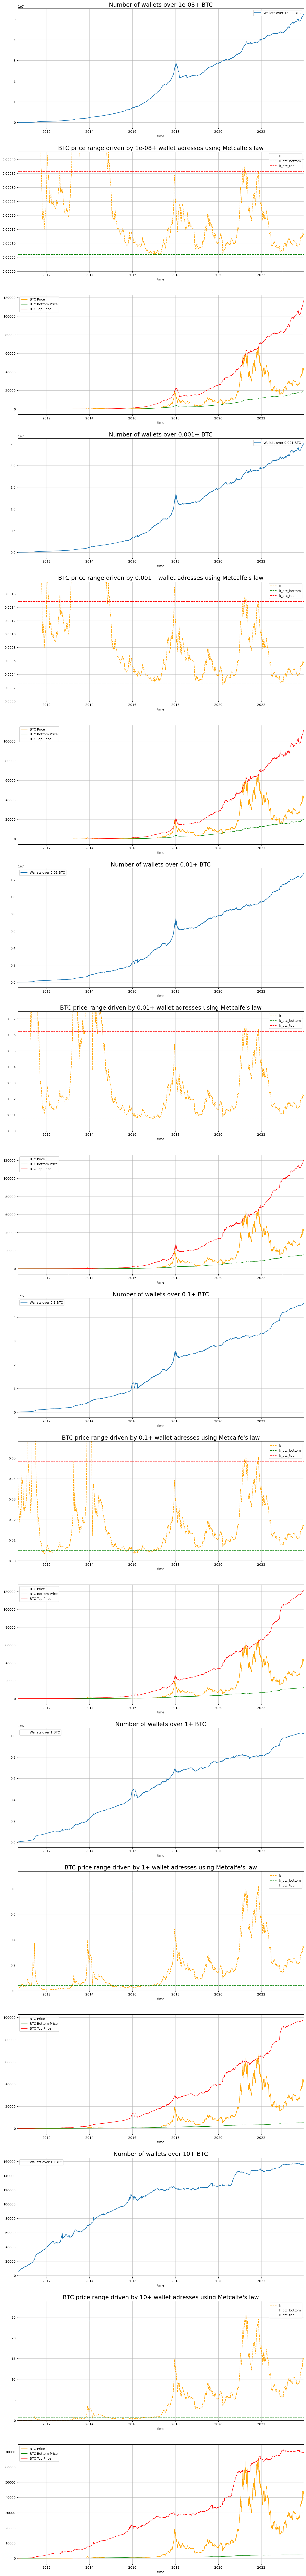

In [8]:
import matplotlib.pyplot as plt
today=df[df[coin]['all']['price'] >0 ].index.max()
subplots = len(min_btcs)*3;
fig, axs = plt.subplots(subplots)
fig.set_size_inches(16, 8*subplots)

i=0
for min_btc in min_btcs:
#for i in range(1,subplots,2) :
    wallet_range = str(min_btc)+'+'
    axs[i].set_title("Number of wallets over {} {}".format(wallet_range, coin), fontsize=18)
    df[coin][str(min_btc)+'+']['addressesCount'][plot_start_date:today].plot(ax=axs[i],label='Wallets over {} {}'.format(min_btc, coin) )
    axs[i].legend(loc='best')
    axs[i].grid(axis='both', which='major', alpha=0.6)
    axs[i].grid(axis='both', which='minor', alpha=0.15)  
    
 
    axs[i+1].set_title("Metcalfe's k range for wallets with {} {}".format(wallet_range, coin), fontsize=18)
    df[coin][wallet_range]['k-sma7d'][plot_start_date:today].plot(ax=axs[i+1],color='orange',label='k'.format(wallet_range, coin), linestyle='dashed')
    (df[coin][wallet_range]['k_btc_bottom'][plot_start_date:today]*btc_max_supply).plot(ax=axs[i+1],color='green',label='k_btc_bottom', linestyle='dashed')
    (df[coin][wallet_range]['k_btc_top'][plot_start_date:today]*btc_max_supply).plot(ax=axs[i+1],color='red',label='k_btc_top', linestyle='dashed')
    axs[i+1].legend(loc='best')
    axs[i+1].grid(which='major', alpha=0.6)
    axs[i+1].grid(which='minor', alpha=0.15)
    axs[i+1].set_ylim([0,df[coin][wallet_range]['k_btc_top'][plot_start_date:today].max()*1.2*btc_max_supply])

    axs[i+1].set_title("{} price range driven by {} wallet adresses using Metcalfe's law".format(coin, wallet_range), fontsize=18)

    #m2_adj_='m2_adj_'
    m2_adj_=''
    if 'm2_adj_'  == m2_adj_:
        m2_adj_text = "USD M2 Supply adjusted "
    else:
         m2_adj_text = ""
    df[coin]['all'][m2_adj_ + 'price'][plot_start_date:today].plot(ax=axs[i+2], linewidth=1, color='orange',label='{}{} Price'.format(m2_adj_text, coin))
    df[coin][wallet_range][m2_adj_ + 'bottom_price'][plot_start_date:today].plot(ax=axs[i+2], linewidth=1,color='green',label='{}{} Bottom Price'.format(m2_adj_text, coin)) 
    df[coin][wallet_range][m2_adj_ + 'top_price'][plot_start_date:today].plot(ax=axs[i+2], linewidth=1,color='red',label='{}{} Top Price'.format(m2_adj_text, coin)) 
    #axs[i+1].set_yscale('log')
    axs[i+2].legend(loc='best')
    axs[i+2].grid(which='major', alpha=0.6)
    axs[i+2].grid(which='minor', alpha=0.15)     
    i=i+3

In [9]:
import math
import numpy as np
from datetime import date
def linear_growth(n,p_0,k):
    return k*n
def quadratic_growth(n,p_0,k):
    return k*n*n
def n_log_n_growth(n,p_0,k):
    return k*n*np.log2(n)

def limited_growth_function_log(t,p_0,k,l):
    return np.log2(l*p_0/( (l-p_0)*(math.e ** (-k*t))+p_0))
def limited_growth_function(t,p_0,k,l):
    return l*p_0/( (l-p_0)*(math.e ** (-k*t))+p_0)

from scipy.optimize import curve_fit
#p_0 = 314.25
p_0 = 4300000000.0
t_0 = pd.Timestamp('2015-01-01')
k = 7445.7718443355325
#l = 1*1000*1000*1000000

df.loc(axis=1)[(coin,'all','delta_days')] = (df.index-t_0).days
    

df

/tmp/ipykernel_20894/2552325190.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc(axis=1)[(coin,'all','delta_days')] = (df.index-t_0).days


coin                    BTC                                            \
wallet_range    1e-08-0.001                  0.001-0.01                 
metrics      addressesCount  totalVolume addressesCount   totalVolume   
time                                                                    
2010-01-01                0     0.000000              0      0.000000   
2010-01-02                0     0.000000              0      0.000000   
2010-01-03                0     0.000000              0      0.000000   
2010-01-04                0     0.000000              0      0.000000   
2010-01-05                0     0.000000              0      0.000000   
...                     ...          ...            ...           ...   
2023-12-21         27252782  5640.481293       12301951  44869.184221   
2023-12-22         27267033  5646.508437       12305834  44852.881423   
2023-12-23         27303043  5655.732066       12288361  44828.299447   
2023-12-24         27350631  5664.453593       12295281  44832.274668   
2023-12-25         27381644  5675.262167       12311567  44882.531910   

coin                                                                     \
wallet_range       0.01-0.1                         0.1-1                 
metrics      addressesCount    totalVolume addressesCount   totalVolume   
time                                                                      
2010-01-01                6       0.080000              3  1.500000e+00   
2010-01-02                6       0.080000              3  1.500000e+00   
2010-01-03                6       0.080000              3  1.500000e+00   
2010-01-04                6       0.080000              3  1.500000e+00   
2010-01-05                6       0.080000              3  1.500000e+00   
...                     ...            ...            ...           ...   
2023-12-21          8140116  274181.576477        3559771  1.100495e+06   
2023-12-22          8139320  274142.550265        3557676  1.099868e+06   
2023-12-23          8140019  273977.480065        3556053  1.099522e+06   
2023-12-24          8138175  273956.657470        3555525  1.099496e+06   
2023-12-25          8139388  273890.734767        3553855  1.099033e+06   

coin                                       ...                                 \
wallet_range           1-10                ...            1+                    
metrics      addressesCount   totalVolume  ...     k_btc_top m2_adj_top_price   
time                                       ...                                  
2010-01-01               10  2.344000e+01  ...  3.722444e-08        33.390412   
2010-01-02               10  2.344000e+01  ...  3.722444e-08        33.671950   
2010-01-03               10  2.344000e+01  ...  3.722444e-08        34.089715   
2010-01-04               10  2.344000e+01  ...  3.722444e-08        34.317645   
2010-01-05               10  2.344000e+01  ...  3.722444e-08        34.766682   
...                     ...           ...  ...           ...              ...   
2023-12-21           867978  2.155350e+06  ...  3.722444e-08     38981.359789   
2023-12-22           867839  2.155546e+06  ...  3.722444e-08     38976.864972   
2023-12-23           867864  2.155841e+06  ...  3.722444e-08     38978.693341   
2023-12-24           868041  2.156818e+06  ...  3.722444e-08     38993.321837   
2023-12-25           867672  2.155792e+06  ...  3.722444e-08     38962.620399   

coin                                                                       \
wallet_range                         10+                                    
metrics          top_price  k_btc_bottom m2_adj_bottom_price bottom_price   
time                                                                        
2010-01-01       34.148881  3.674432e-08           32.937737    33.685924   
2010-01-02       34.436815  3.674432e-08           33.215551    33.970049   
2010-01-03       34.864070  3.674432e-08           33.627791    34.391653   
2010-01-04       35.097

In [10]:
guess = [p_0, k]
today=df[df[coin]['all']['price'] >0 ].index.max()
min_date = df.index.min()
ix = pd.date_range(start=min_date, end=date.fromisoformat(extrapolation_end_date), freq='D')
df = df.reindex(ix)
df.loc(axis=1)[(coin,'all','delta_days')] = (df.index-t_0).days
#linear_fitting_start_date='2022-01-01'
print(today)

for min_btc in min_btcs:
    wallet_range = str(min_btc) + '+'
    parameters, covariance = curve_fit(linear_growth, df[coin]['all']['delta_days'][linear_fitting_start_date:today], df['BTC'][wallet_range]['addressesCount'][linear_fitting_start_date:today],p0=guess)
    print("p_0={}, k={}".format(parameters[0],parameters[1]))
    df.loc(axis=1)[(coin,wallet_range,'addressesCount_linear_guess')]= linear_growth((df.index-t_0).days,p_0,k)
    df.loc(axis=1)[(coin,wallet_range,'addressesCount_linear_fit')]= linear_growth((df.index-t_0).days,parameters[0],parameters[1])

    df.loc(axis=1)[(coin, wallet_range, 'm2_adj_bottom_price_linear_fit')] = \
        k_btc_bottom * df.loc(axis=1)[(coin,wallet_range,'addressesCount_linear_fit')]**2
    df.loc(axis=1)[(coin, wallet_range, 'bottom_price_linear_fit')] = \
    df.loc(axis=1)[(coin, wallet_range, 'm2_adj_bottom_price_linear_fit')]  * df.loc(axis=1)[('USD','all', 'm2_supply_index')][today]   

    df.loc(axis=1)[(coin, wallet_range, 'm2_adj_top_price_linear_fit')] = \
        k_btc_top * df.loc(axis=1)[(coin,wallet_range,'addressesCount_linear_fit')]**2
    df.loc(axis=1)[(coin, wallet_range, 'top_price_linear_fit')] = \
    df.loc(axis=1)[(coin, wallet_range, 'm2_adj_top_price_linear_fit')]  * df.loc(axis=1)[('USD','all', 'm2_supply_index')][today]   
    
df


2023-12-25 00:00:00
p_0=4300000000.0, k=15516.40336695717
p_0=4300000000.0, k=7573.321701746269
p_0=4300000000.0, k=3821.8463760113573
p_0=4300000000.0, k=1372.1460732463613
p_0=4300000000.0, k=326.2808142252814
p_0=4300000000.0, k=54.354005112443446


/Users/szabolcsbeki/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_20894/1517149025.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc(axis=1)[(coin,wallet_range,'addressesCount_linear_guess')]= linear_growth((df.index-t_0).days,p_0,k)
/tmp/ipykernel_20894/1517149025.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc(axis=1)[(coin,

coin                    BTC                                         \
wallet_range    1e-08-0.001                 0.001-0.01               
metrics      addressesCount totalVolume addressesCount totalVolume   
2010-01-01              0.0         0.0            0.0         0.0   
2010-01-02              0.0         0.0            0.0         0.0   
2010-01-03              0.0         0.0            0.0         0.0   
2010-01-04              0.0         0.0            0.0         0.0   
2010-01-05              0.0         0.0            0.0         0.0   
...                     ...         ...            ...         ...   
2037-06-22              NaN         NaN            NaN         NaN   
2037-06-23              NaN         NaN            NaN         NaN   
2037-06-24              NaN         NaN            NaN         NaN   
2037-06-25              NaN         NaN            NaN         NaN   
2037-06-26              NaN         NaN            NaN         NaN   

coin                                                                \
wallet_range       0.01-0.1                      0.1-1               
metrics      addressesCount totalVolume addressesCount totalVolume   
2010-01-01              6.0        0.08            3.0         1.5   
2010-01-02              6.0        0.08            3.0         1.5   
2010-01-03              6.0        0.08            3.0         1.5   
2010-01-04              6.0        0.08            3.0         1.5   
2010-01-05              6.0        0.08            3.0         1.5   
...                     ...         ...            ...         ...   
2037-06-22              NaN         NaN            NaN         NaN   
2037-06-23              NaN         NaN            NaN         NaN   
2037-06-24              NaN         NaN            NaN         NaN   
2037-06-25              NaN         NaN            NaN         NaN   
2037-06-26              NaN         NaN            NaN         NaN   

coin                                     ...                                 \
wallet_range           1-10              ...                             1+   
metrics      addressesCount totalVolume  ... m2_adj_bottom_price_linear_fit   
2010-01-01             10.0       23.44  ...                   13042.918553   
2010-01-02             10.0       23.44  ...                   13028.636683   
2010-01-03             10.0       23.44  ...                   13014.362637   
2010-01-04             10.0       23.44  ...                   13000.096414   
2010-01-05             10.0       23.44  ...                   12985.838015   
...                     ...         ...  ...                            ...   
2037-06-22              NaN         NaN  ...                  263540.843401   
2037-06-23              NaN         NaN  ...                  263605.062918   
2037-06-24              NaN         NaN  ...                  263669.290258   
2037-06-25              NaN         NaN  ...                  263733.525422   
2037-06-26              NaN         NaN  ...                  263797.768410   

coin                                                              \
wallet_range                                                       
metrics      bottom_price_linear_fit m2_adj_top_price_linear_fit   
2010-01-01              32716.349832                4.075967e+05   
2010-01-02              32680.525745                4.071504e+05   
2010-01-03              32644.721282                4.067044e+05   
2010-01-04              32608.936444                4.062585e+05   
2010-01-05              32573.171229                4.058129e+05   
...                              ...                         ...   
2037-06-22             661055.605961                8.235763e+06   
2037-06-23             661216.691701                8.237770e+06   
2037-06-24             661377.797064                8.239777e+06   
2037-06-25             661538.922052                8.241785e+06   
2037-06-26             661700.066665           

In [11]:
#df.loc(axis=1)[('BTC_AdrBal1in10BCnt_func_unlimited')]=1000000
min_date = df.index.min()

def linear_growth_func(y_previous,a):
    return y_previous+a
def unlimited_growth_func(y_previous,r):
    return y_previous+r*y_previous
def logistic_growth_func(y_previous,r,M,m=1):
    return y_previous+y_previous*r*(1-(y_previous/M))**(1/m)

for min_btc in min_btcs:
    initial_wallets =  df.loc(axis=1)[(coin,wallet_range,'addressesCount')][min_date]

    wallet_range = str(min_btc) + '+'
    i = 0
    y_prev=initial_wallets
    for index, row in df.iterrows():
        y=logistic_growth_func(y_prev,1/450,50*1000*1000,1/4)
        df.loc[index,(coin, wallet_range, 'addressesCount_logistic_guess_A')] =y
        y_prev=y
        i=i+1
for min_btc in min_btcs:
    initial_wallets =  df.loc(axis=1)[(coin,wallet_range,'addressesCount')][min_date]

    wallet_range = str(min_btc) + '+'
    i = 0
    y_prev=initial_wallets
    for index, row in df.iterrows():
        y=logistic_growth_func(y_prev,1/450,100*1000*1000,1/9)
        df.loc[index,(coin, wallet_range, 'addressesCount_logistic_guess_B')] =y
        y_prev=y
        i=i+1    
for min_btc in min_btcs:
    initial_wallets =  df.loc(axis=1)[(coin,wallet_range,'addressesCount')][min_date]

    wallet_range = str(min_btc) + '+'
    i = 0
    y_prev=initial_wallets
    for index, row in df.iterrows():
        y=logistic_growth_func(y_prev,1/450,200*1000*1000,1/18)
        df.loc[index,(coin, wallet_range, 'addressesCount_logistic_guess_C')] =y
        y_prev=y
        i=i+1    

df

/tmp/ipykernel_20894/2828885498.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index,(coin, wallet_range, 'addressesCount_logistic_guess_A')] =y
/tmp/ipykernel_20894/2828885498.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index,(coin, wallet_range, 'addressesCount_logistic_guess_B')] =y
/tmp/ipykernel_20894/2828885498.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

coin                    BTC                                         \
wallet_range    1e-08-0.001                 0.001-0.01               
metrics      addressesCount totalVolume addressesCount totalVolume   
2010-01-01              0.0         0.0            0.0         0.0   
2010-01-02              0.0         0.0            0.0         0.0   
2010-01-03              0.0         0.0            0.0         0.0   
2010-01-04              0.0         0.0            0.0         0.0   
2010-01-05              0.0         0.0            0.0         0.0   
...                     ...         ...            ...         ...   
2037-06-22              NaN         NaN            NaN         NaN   
2037-06-23              NaN         NaN            NaN         NaN   
2037-06-24              NaN         NaN            NaN         NaN   
2037-06-25              NaN         NaN            NaN         NaN   
2037-06-26              NaN         NaN            NaN         NaN   

coin                                                                \
wallet_range       0.01-0.1                      0.1-1               
metrics      addressesCount totalVolume addressesCount totalVolume   
2010-01-01              6.0        0.08            3.0         1.5   
2010-01-02              6.0        0.08            3.0         1.5   
2010-01-03              6.0        0.08            3.0         1.5   
2010-01-04              6.0        0.08            3.0         1.5   
2010-01-05              6.0        0.08            3.0         1.5   
...                     ...         ...            ...         ...   
2037-06-22              NaN         NaN            NaN         NaN   
2037-06-23              NaN         NaN            NaN         NaN   
2037-06-24              NaN         NaN            NaN         NaN   
2037-06-25              NaN         NaN            NaN         NaN   
2037-06-26              NaN         NaN            NaN         NaN   

coin                                     ...                                  \
wallet_range           1-10              ...                           0.01+   
metrics      addressesCount totalVolume  ... addressesCount_logistic_guess_B   
2010-01-01             10.0       23.44  ...                    3.002540e+04   
2010-01-02             10.0       23.44  ...                    3.009194e+04   
2010-01-03             10.0       23.44  ...                    3.015863e+04   
2010-01-04             10.0       23.44  ...                    3.022547e+04   
2010-01-05             10.0       23.44  ...                    3.029245e+04   
...                     ...         ...  ...                             ...   
2037-06-22              NaN         NaN  ...                    3.597237e+07   
2037-06-23              NaN         NaN  ...                    3.597382e+07   
2037-06-24              NaN         NaN  ...                    3.597526e+07   
2037-06-25              NaN         NaN  ...                    3.597671e+07   
2037-06-26              NaN         NaN  ...                    3.597815e+07   

coin                                                                          \
wallet_range                            0.1+                              1+   
metrics      addressesCount_logistic_guess_B addressesCount_logistic_guess_B   
2010-01-01                      3.002540e+04                    3.001938e+04   
2010-01-02                      3.009194e+04                    3.008591e+04   
2010-01-03                      3.015863e+04                    3.015259e+04   
2010-01-04                      3.022547e+04                    3.021941e+04   
2010-01-05                      3.029245e+04                    3.028639e+04   
...                                      ...                             ...   
2037-06-22                      3.597237e+07                    3.597224e+07   
2037-06-23                      3.597382e+07                    3.597369e+07   
2037-06-24                      3.597

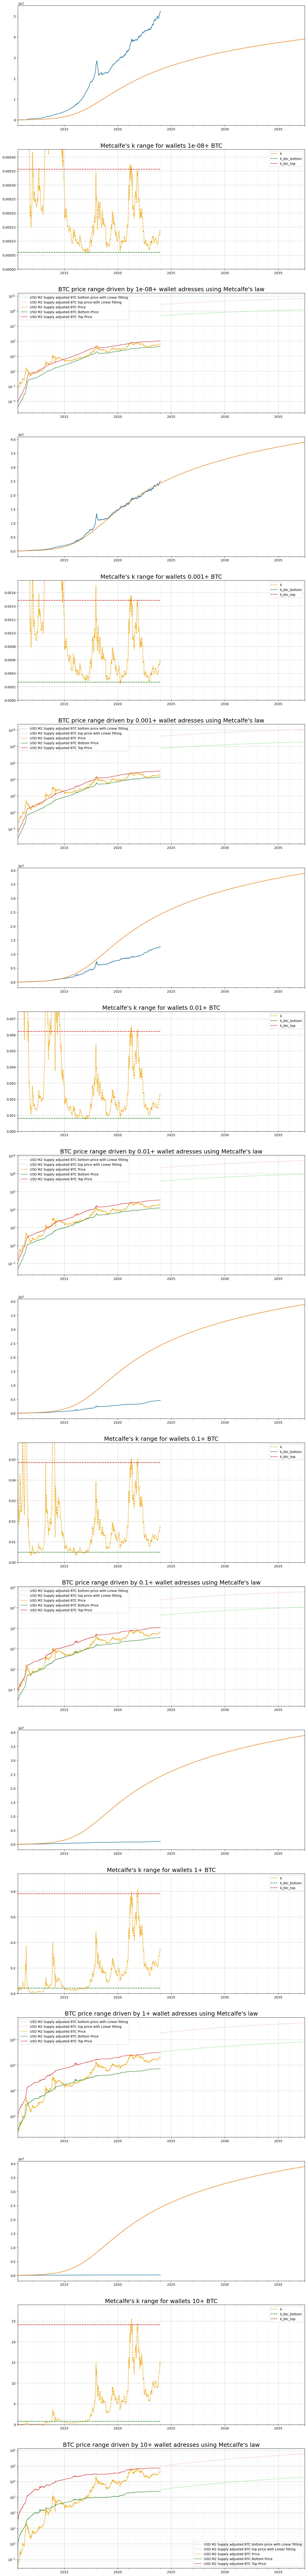

In [12]:
import matplotlib.pyplot as plt
subplots = len(min_btcs)*3;
fig, axs = plt.subplots(subplots)
fig.set_size_inches(16, 8*subplots)

i=0


for min_btc in min_btcs:
    wallet_range = str(min_btc)+'+'
#    df[coin][str(min_btc)+'+']['addressesCount_linear_fit'][plot_start_date:].plot(ax=axs[0],label='Wallets over {} {} with linear curve fitting'.format(min_btc, coin) )
#    df[coin][str(min_btc)+'+']['addressesCount_linear_guess'].plot(ax=axs[0],label='Wallets over {} {} with linear guess'.format(min_btc, coin) )
    df[coin][str(min_btc)+'+']['addressesCount'][plot_start_date:today].plot(ax=axs[i],label='Wallets over {} {}'.format(min_btc, coin) )
#    df[coin][str(min_btc)+'+']['addressesCount_logistic_guess_A'][plot_start_date:].plot(ax=axs[i],label='Wallets over {} {} with logistic growth A'.format(min_btc, coin) )
#    df[coin][str(min_btc)+'+']['addressesCount_logistic_guess_B'][plot_start_date:].plot(ax=axs[i],label='Wallets over {} {} with logistic growth B'.format(min_btc, coin) )
    df[coin][str(min_btc)+'+']['addressesCount_logistic_guess_C'][plot_start_date:].plot(ax=axs[i],label='Wallets over {} {} with logistic growth C'.format(min_btc, coin) )

    

    axs[i+1].set_title("Metcalfe's k range for wallets {} {}".format(wallet_range, coin), fontsize=18)
    df[coin][wallet_range]['k-sma7d'][plot_start_date:].plot(ax=axs[i+1],color='orange',label='k'.format(wallet_range, coin), linestyle='dashed')
    (df[coin][wallet_range]['k_btc_bottom'][plot_start_date:]*btc_max_supply).plot(ax=axs[i+1],color='green',label='k_btc_bottom', linestyle='dashed')
    (df[coin][wallet_range]['k_btc_top'][plot_start_date:]*btc_max_supply).plot(ax=axs[i+1],color='red',label='k_btc_top', linestyle='dashed')
    axs[i+1].legend(loc='best')
    axs[i+1].set_ylim([0,df[coin][wallet_range]['k_btc_top'][plot_start_date:today].max()*1.2*btc_max_supply])
 
    axs[i+1].grid(which='major', alpha=0.6)
    axs[i+1].grid(which='minor', alpha=0.15) 
    axs[i+2].set_title("{} price range driven by {} wallet adresses using Metcalfe's law".format(coin, wallet_range), fontsize=18)

    #m2_adj_='m2_adj_'
    m2_adj_=''
    wallet_range
    df[coin][wallet_range][m2_adj_ + 'bottom_price_linear_fit'][today:].plot(ax=axs[i+2], linewidth=1, color='lightgreen',label='USD M2 Supply adjusted {} bottom price with Linear fitting'.format(coin))
    df[coin][wallet_range][m2_adj_ + 'top_price_linear_fit'][today:].plot(ax=axs[i+2], linewidth=1, color='pink',label='USD M2 Supply adjusted {} top price with Linear fitting'.format(coin))

    df[coin]['all'][m2_adj_ + 'price'][plot_start_date:].plot(ax=axs[i+2], linewidth=1, color='orange',label='USD M2 Supply adjusted {} Price '.format(coin))

    df[coin][wallet_range][m2_adj_ + 'bottom_price'][plot_start_date:].plot(ax=axs[i+2], linewidth=1,color='green',label='USD M2 Supply adjusted {} Bottom Price'.format(coin)) 
    df[coin][wallet_range][m2_adj_ + 'top_price'][plot_start_date:].plot(ax=axs[i+2], linewidth=1,color='red',label='USD M2 Supply adjusted {} Top Price'.format(coin)) 
    axs[i+2].set_yscale('log')
    axs[i+2].legend(loc='best')
    axs[i+2].grid(which='major', alpha=0.6)
    axs[i+2].grid(which='minor', alpha=0.15) 
    i=i+3